# **Menu List Crawling**

## **1 청심중고교 메뉴 데이터 호출**
무영 메뉴작업 목록 호출하기
```python
from muyong.food import menu_chungsim
from tqdm import tqdm
date   = [str(_).split(" ")[0][:-3]  for _ in pd.date_range(start='1/1/2017', end="8/1/2019", freq='MS')]
result = [menu_chungsim(_).values.tolist()  for _ in tqdm(date)]
temp   = []
for _ in result:
    temp.extend(_)
temp = pd.DataFrame(temp, columns = ["Date", "조식", "중식", "석식"])
```

In [2]:
# 2017-01-01 부터 수집 가능합니다.
import pandas as pd
df = pd.read_csv('data/menu_chungsim.csv')
df.head(2)

,Date,조식,중식,석식
0,2017-01-01,찰현미밥.떡만두국.진미채무침.계란찜.롤케익.골드파인애플/초코첵스,하이라이스..돈목살스테이크/소스.치즈스틱/케찹.양송이버섯볶음.포기김치.이오 大,찹쌀밥.된장찌개.한우버섯불고기.깐쇼새우.꽃상추무침.포기김치.쁘띠첼(90g)(핫도그....
1,2017-01-02,찹쌀현미밥.돈육김치찌개.베이컨스크램블.코다리조림.부시맨빵/버터.후르트링/밀감,혼합잡곡밥.사골우거지국.후라이드치킨/허니머스터드.꽈리고추메추리알조림.비타민무침.깍두...,보리밥.맑은콩나물국.한우갈비찜.팔보채.오이양파무침.포기김치.장프로바이오틱(주먹밥.카...


## **2 성균관 대학교 메뉴 데이터 호출**
무영 메뉴작업 목록 호출하기 : 1년 전까지만 호출가능
```python
div class="weekly_list"
div class="tabCon listcon1"
div class="weeListWrap"   # div class="weeListTit" : 날짜만 추출시
idx_date_range = [_.date().strftime("%Y-%m-%d")  
    for _ in pd.date_range(start=idx_date, periods=len(menu_detail))]
```

<br></br>
# **10,000 개의 레시피 메뉴 함수**
개별 작업을 구분한 뒤, 모듈로써 작업을 진행하도록 합니다
1. **크롤링용** 함수
1. 원본과 **비교용** 함수
1. **비교 후 합치는** 함수

## **1 작업용 함수 만들기**
크롤링 및 주소값을 활요한 filtering

In [1]:
# "<제목>" 추출시 lxml 로는 안되더라 왜????
import requests, re
from bs4 import BeautifulSoup
def crawMenuBs4(url_no):
    url          = "http://www.10000recipe.com/recipe/list.html?order=date&page="
    userAgent    = {"user-agent":"Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:61.0) Gecko/20100101 Firefox/61.0"}
    result, resp = [], requests.request('get', url+str(url_no), headers=userAgent, timeout=5)
    dom          = BeautifulSoup(resp.text, "html.parser") 
    titles       = dom.find_all("h4", {"class":"ellipsis_title2"})
    titles       = [_.text   for _ in titles]
    for _ in dom.find_all("div", {"class":"col-xs-4"}):
        try:
            url_href = _.find("a", {"class":"thumbnail"})["href"]
            _title   = _.find("h4", {"class":"ellipsis_title2"}).text
            result.append([url_href, _title])
        except: pass
    return result
        
# 특정 페이지 링크데이터 목록 수집하기
menuList = crawMenuBs4(17)
menuList[:3]

[['/recipe/6917104', '콩국수 ~#'],
 ['/recipe/6917103', '5분이면 가능한 "건새우 볶음"'],
 ['/recipe/6917102', '간단 참치전~*']]

In [1]:
# 파일을 기준으로 결과물 필터링
import pandas as pd
def crawFileFilter(menuList, files):
    df = pd.read_csv(files, header=None)
    limitOrg = int(re.findall(r"\d+", df[0][0])[0])
    mTemp    = pd.DataFrame(menuList)
    mTemp[0] = [int(re.findall(r"\d+", _)[0]) for _ in mTemp[0]]
    mTemp    = mTemp[mTemp[0] > limitOrg]
    mTemp[0] = ["/recipe/"+str(_) for _ in mTemp[0]] # 필터링 결과 url
    return mTemp.values.tolist()

In [103]:
# Web Page 수집함수
import requests
from lxml.html import fromstring
def crawData(url_menu):
    url        = "http://www.10000recipe.com/recipe/list.html?order=accuracy&page="
    url        = "http://www.10000recipe.com/recipe/"
    userAgent  = {"user-agent":"Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:61.0) Gecko/20100101 Firefox/61.0"}
    xpath_rcp  = '//div[@id="contents_area"]//div[starts-with(@class,"cont_ingre")]//text()'
    xpath_c    = '//div[@id="contents_area"]/div[@class="view_step"]/div[starts-with(@id,"stepDiv")]//text()'
    xpath_cOld = '//div[@id="contents_area"]/div[@class="view_step"]/div[@id="oldContArea"]//text()'
    xpath_tip  = '//div[@id="contents_area"]/div[@class="view_step"]//dl[@class="view_step_tip"]//text()'
    xpath_name = '//div[@id="contents_area"]/div[@class="view2_summary"]/h3/text()'
    urlDetail  = requests.compat.urljoin(url, url_menu)
    # urlDetail  = url + str(url_menu)
    resp       = requests.request('get', urlDetail, headers=userAgent, timeout=5)
    resp_lxml  = fromstring(resp.text)
    try:
        name = resp_lxml.xpath(xpath_name)  # 레시피 데이터
        name = " ".join([_.strip()    for _ in name if len(_.strip())>1])
        recipe = resp_lxml.xpath(xpath_rcp) # 레시피 데이터
        recipe = " ".join([_.strip()  for _ in recipe if len(_.strip())>1])
        cooking = resp_lxml.xpath(xpath_c)  # 조리법 크롤링
        cooking = " ".join([_.strip() for _ in cooking if len(_.strip())>1])
        if len(cooking) < 5:                # 조리법 크롤링 (old style)
            cooking = resp_lxml.xpath(xpath_cOld)
            cooking = " ".join([_.strip() for _ in cooking if len(_.strip())>1])
        cookTip = resp_lxml.xpath(xpath_tip)
        cookTip = " ".join([_.strip()  for _ in cookTip if len(_.strip())>1])
        if len(cookTip) < 3: cookTip="None"
        # url 은 레시피 Url 숫자 저장 (압축)
        url_menu = int("".join(re.findall(r'\d+', url_menu)))
        return [url_menu, name, recipe, cooking, cookTip]
    except: return None

## **2 레시피 데이터 전처리**
작업한 내용 살펴보기

In [11]:
# import pandas as pd
# recipes    = pd.read_csv('data/foodRecipe.csv', sep="|", header=None)
# recipes[0] = [int(_)  for _ in recipes[0]] # 문자열 대신 숫자로 모두 변환

# # 중복 컬럼 줄이기 : 6917054, 6917053, 6917052, 6917051, 6917050, 6917049
# from tqdm import tqdm
# result, recipesNo = [], sorted(set(recipes[0]), reverse=True)
# for _ in tqdm(recipesNo):
#     result.append(recipes[recipes[0] == _].iloc[0,:].values.tolist())
# recipes           = pd.DataFrame(result)
# recipes.to_csv('recipe.csv', index=None, header=None, sep="|")
# recipes.head(2)

<br></br>
# **Naver 자료 수집하기**
Naver 자료들 수집하기

## **1 네이버 블로그 내용 수집하기**
블로그 URL 에서 본문을 수집 분석하기

In [6]:
# iframe 으로 본문 url 찾은 뒤, //div[@id="postListBody"] 내용의 출력
import requests
from lxml.html import fromstring

def get_blog_post(url):
    userAgent   = {"user-agent":"Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:61.0) Gecko/20100101 Firefox/61.0"}
    rsp         = requests.get(url, headers=userAgent)
    rsp_lxml    = fromstring(rsp.text) # './/태그[contains(@속성명, "속성값")]'
    text_result = rsp_lxml.xpath('.//iframe[@id="mainFrame"]/@src')
    get_url     = "https://blog.naver.com" + text_result[0]
    resp        = requests.get(get_url)
    resp_lxml   = fromstring(resp.text)
    blog_xpath  = '//div[@id="postListBody"]//table//text()'
    return " ".join([_.strip() for _ in resp_lxml.xpath(blog_xpath) if _.strip()])

url = "https://blog.naver.com/k77609/221366368354"
url = 'https://blog.naver.com/0167513714/221616708943'
url = 'https://blog.naver.com/hnn888/221411518781'
blog_text = get_blog_post(url)
blog_text[:250]

'요리하다 [김치만두전골 황금레시피]알배추를 넣어 얼큰한 겨울국물요리 캐리정 ・ 2018. 12. 3. 21:30 URL 복사 이웃추가 본문 기타 기능 번역보기 얼큰한 겨울 국물요리 김치만두전골 황금레시피 으슬으슬 추 운 계절에는 얼큰 시원한 국물요리만한게 없죠 여기에 든든한 만두가 가세한 만두 전골냄비 한 그릇만으로 다른 반찬 필요없어용~ 김치만두전골 황금레시피 컨셉: 든든한 국물요리 ** 만두전골 재료 2인분\xa0** 직접 만든 김치손만두 4개 '

In [7]:
from konlpy.tag import Okt
blog_text
tokens = [_[0]+"/"+_[1]  for _ in Okt().pos(blog_text, stem=True)]

from nltk import Text
token_blog = Text(tokens)   # [list] 객체로 Text 객체의 생성

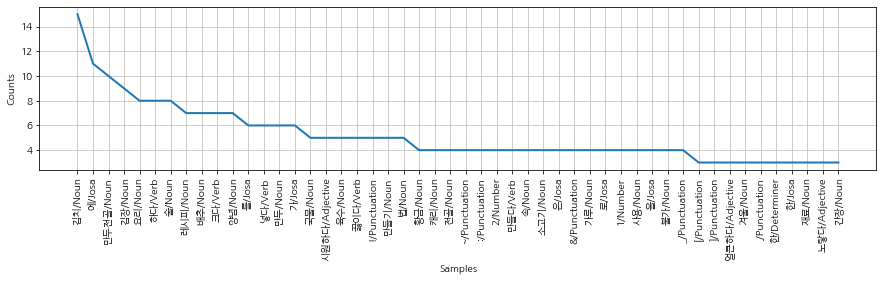

In [8]:
%matplotlib inline
from matplotlib import rc, rcParams
import matplotlib.pyplot as plt
rc('font', family=['NanumGothic','Malgun Gothic']) # 한글의 표시
rcParams['axes.unicode_minus'] = False             # '-' 표시의 처리
plt.figure(figsize=(15, 3))  # 파레트 설정
token_blog.plot(50)

# **Naver Post Detail Crawling**
메뉴의 이름들 중 대표성 높은 메뉴들 찾기

## **1 네이버 블로그 내용 수집하기**
블로그 URL 에서 본문을 수집 분석하기
1. Naver OPEN API 결과 **Token 이 유효값인지** 확인 가능했다 (Oh!!)
1. 네이버 블로그 목록만 정리한 DataBase 만들기
1. 목록을 4개로 나워서 2개의 서버에서 돌리며 저장하기

In [4]:
import re
# 수집결과 불필요한 기호들 제거하는 함수
def blog_preprocess(post):
    post_temp = post.replace('\n',"").replace('\t',"").split(".")
    post_temp = [" ".join(re.findall(r"[가-힣0-9A-z]+", _))  for _ in post_temp  if len(_.strip()) >= 1]
    return ".".join(post_temp)

In [2]:
# import pandas as pd
# links_org      = pd.read_csv('backup/naver_link_temp.csv')
# # links_org.shape, links_org.head(3)
# links_by_token = links_org.iloc[::60, :] # 길이를 절반으로 축소
# links_by_token = links_by_token.data.values.tolist()
# len(links_by_token), links_by_token[0][:40]

In [3]:
# import sqlite3, time, os, requests_cache
# file_db = "naver.db"
# conn = sqlite3.connect(file_db)
# requests_cache.install_cache('cache')

# import pandas as pd
# from tqdm import tqdm
# from muyong.util import Telegram
# from muyong.naver import get_blog_post
# t = Telegram()
# links_length = len(links_by_token)
# for no, links in tqdm(enumerate(links_by_token)):
#     result, temp = [], []
#     links = links.split('|')
#     for _ in links[:100]:
#         _ = get_blog_post(_)
#         _ = blog_preprocess(_)
#         temp.append(_)
#         time.sleep(.1)
#     temp = "|".join(temp)     # 500개를 저장
#     result.append([no, temp])
#     df = pd.DataFrame(result)
#     df.to_sql('foods', conn, if_exists='append')
#     os.remove("cache.sqlite")
#     if no % 200 == 0:
#         t.msg("{}/ {} th processing".format(no, links_length))
#     time.sleep(.1)
# conn.commit()
# conn.close()

## **2 수집결과 살펴보기**
Sqlite 결과를 보다 활용하기 쉽게 저장하기

In [1]:
# import sqlite3
# import pandas as pd
# conn = sqlite3.connect("naver.db")
# df = pd.read_sql('SELECT * FROM "foods"', conn, index_col=None).drop('index', axis=1)
# conn.close()
# df = df.iloc[11:].reset_index(drop=True)
# df.columns = ['Query', 'Posts']
# df.Query = links_org.iloc[::60, 0].tolist()
# df.head()

# df.to_csv("data/naver_posts_sample.csv", index=None)
# df.Query.tolist()